# 0 - Quick Imports

In [1]:
import numpy as np
import PIL
from PIL import Image
import numpy as np
import torch
import os
import sys

sys.path.append('..')
os.path.join(os.path.defpath)
import os

# Construct the path relative to home
# project_path = os.path.join(os.path.expanduser('~'), 'project', 'grepa', 'REPA')
project_path = "./"
# Change the current working directory
os.chdir(project_path)
print(os.getcwd()) # confirm the working directory is the repo root

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/mnt/SSD/lengx/REPA


In [2]:
def display_alongside_batch(img_list, resize_dims=(512,512)):
    if isinstance(resize_dims, int):
        resize_dims = (resize_dims,resize_dims)
    res = np.concatenate([np.array(img.resize(resize_dims)) for img in img_list], axis=1)
    return Image.fromarray(res)

# 1 - Load the model (SiT) and encoder (DINO)

In [3]:
# --model SiT-XL/2 \
#   --num-fid-samples 50000 \
#   --ckpt YOUR_CHECKPOINT_PATH \
#   --path-type=linear \
#   --encoder-depth=8 \
#   --projector-embed-dims=768 \
#   --per-proc-batch-size=64 \
#   --mode=sde \
#   --num-steps=250 \
#   --cfg-scale=1.8 \
#   --guidance-high=0.7

# Load model:
from dataclasses import dataclass
from models.sit import SiT_models
from models.original_sit import SiT_models as Original_SiT_Model
from diffusers.models import AutoencoderKL

# NOTE: Experiment for the REPA checkpoints
@dataclass
class repaArgs():
    vae = 'ema'
    model =  'SiT-XL/2' #'SiT-B/2' #'SiT-XL/2'
    num_classes = 1000
    encoder_depth = 8
    projector_embed_dims = "768"
    fused_attn = True
    qk_norm = False
    resolution = 256
    # ckpt = './exps/sit-b-base-400k/checkpoints/0250000.pt'
    # ckpt = './exps/sit-b-linear-dinov2-b-enc8-400k/checkpoints/0200000.pt'
    ckpt = './pretrained_models/last.pt'
    # ckpt = './pretrained_models/SiT-XL-2-256x256-fixed.pt'
    data_dir = './data/'

args = repaArgs()
device = "cuda:3"

block_kwargs = {"fused_attn": args.fused_attn, "qk_norm": args.qk_norm}
latent_size = args.resolution // 8
model = SiT_models[args.model](
    input_size=latent_size,
    num_classes=args.num_classes,
    use_cfg = True,
    z_dims = [int(z_dim) for z_dim in args.projector_embed_dims.split(',')],
    encoder_depth=args.encoder_depth,
    **block_kwargs,
).to(device)


# Auto-download a pre-trained model or load a custom SiT checkpoint from train.py:
ckpt_path = args.ckpt
state_dict = torch.load(ckpt_path, map_location=f'{device}')#['ema']
if "model" in state_dict:
    state_dict = state_dict["model"]
model.load_state_dict(state_dict)
model.eval()  # important!

vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{args.vae}").to(device)

In [4]:
import torch
from PIL import Image
from samplers import euler_sampler, euler_maruyama_sampler
# Ensure your model and vae are already loaded as in your snippet
from utils.imagenet_idx_to_classnames import imagenet_idx_to_classnames

def sample_images(
    model, 
    vae, 
    class_idx=None,
    batch_size=8,
    resolution=256, 
    num_steps=50, 
    mode='ode', 
    cfg_scale=1.5, 
    guidance_low=0.0, 
    guidance_high=1.0, 
    path_type='linear', 
    num_classes=1000, 
    device='cuda'
):
    """
    Sample images from a SiT model in a simple single-GPU environment.
    
    Parameters:
        model: The loaded SiT model.
        vae: The loaded VAE model from diffusers.
        batch_size (int): Number of images to sample in one batch.
        resolution (int): The output resolution of images.
        num_steps (int): Number of diffusion steps (ODE or SDE steps).
        mode (str): 'ode' or 'sde' sampling mode.
        cfg_scale (float): Classifier-free guidance scale.
        guidance_low (float): Guidance lower bound.
        guidance_high (float): Guidance upper bound.
        path_type (str): 'linear' or 'cosine' for scheduling.
        num_classes (int): Number of classes for the model.
        device (str): Device to run the sampling on.
        
    Returns:
        A list of PIL.Image objects.
    """
    model.eval()
    latent_size = resolution // 8

    # Sample latent noise
    z = torch.randn(batch_size, model.in_channels, latent_size, latent_size, device=device)
    if class_idx:
        y = torch.tensor([class_idx] * batch_size, device=device)
    else:
        # Sample random class labels (if using an ImageNet-like model)
        y = torch.randint(0, num_classes, (batch_size,), device=device)
        
    # Prepare sampler arguments
    sampling_kwargs = dict(
        model=model,
        latents=z,
        y=y, # label condition
        num_steps=num_steps,
        heun=False,  # Set True if you want Heun steps (for ODE sampler)
        cfg_scale=cfg_scale,
        guidance_low=guidance_low,
        guidance_high=guidance_high,
        path_type=path_type,
    )

    with torch.no_grad():
        # Pick the sampler
        if mode == "sde":
            samples = euler_maruyama_sampler(**sampling_kwargs).to(torch.float32)
        elif mode == "ode":
            samples = euler_sampler(**sampling_kwargs).to(torch.float32)
        else:
            raise NotImplementedError("Mode must be 'ode' or 'sde'.")

        # Decode with VAE
        latents_scale = torch.tensor([0.18215]*4).view(1,4,1,1).to(device)
        latents_bias = torch.tensor([0.0]*4).view(1,4,1,1).to(device)
        decoded = vae.decode((samples - latents_bias) / latents_scale).sample
        decoded = (decoded + 1) / 2.0
        decoded = torch.clamp(255. * decoded, 0, 255).permute(0,2,3,1).to("cpu", dtype=torch.uint8).numpy()

    class_idxs = y.detach().cpu().numpy()
    # Convert to PIL images
    images = [Image.fromarray(decoded[i]) for i in range(decoded.shape[0])]
    return images, class_idxs

standard poodle


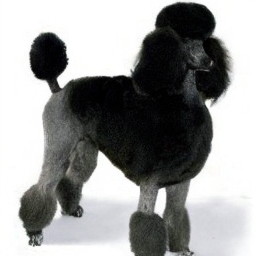

Airedale, Airedale terrier


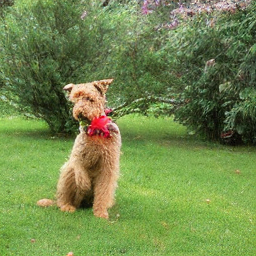

hog, pig, grunter, squealer, Sus scrofa


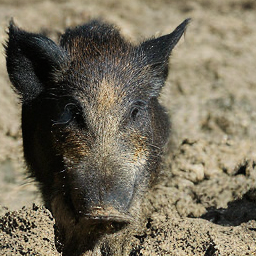

coffee mug


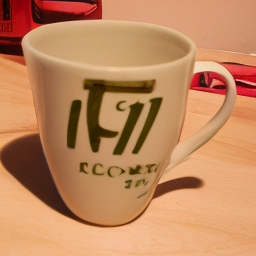

['standard poodle', 'Airedale, Airedale terrier', 'hog, pig, grunter, squealer, Sus scrofa', 'coffee mug']


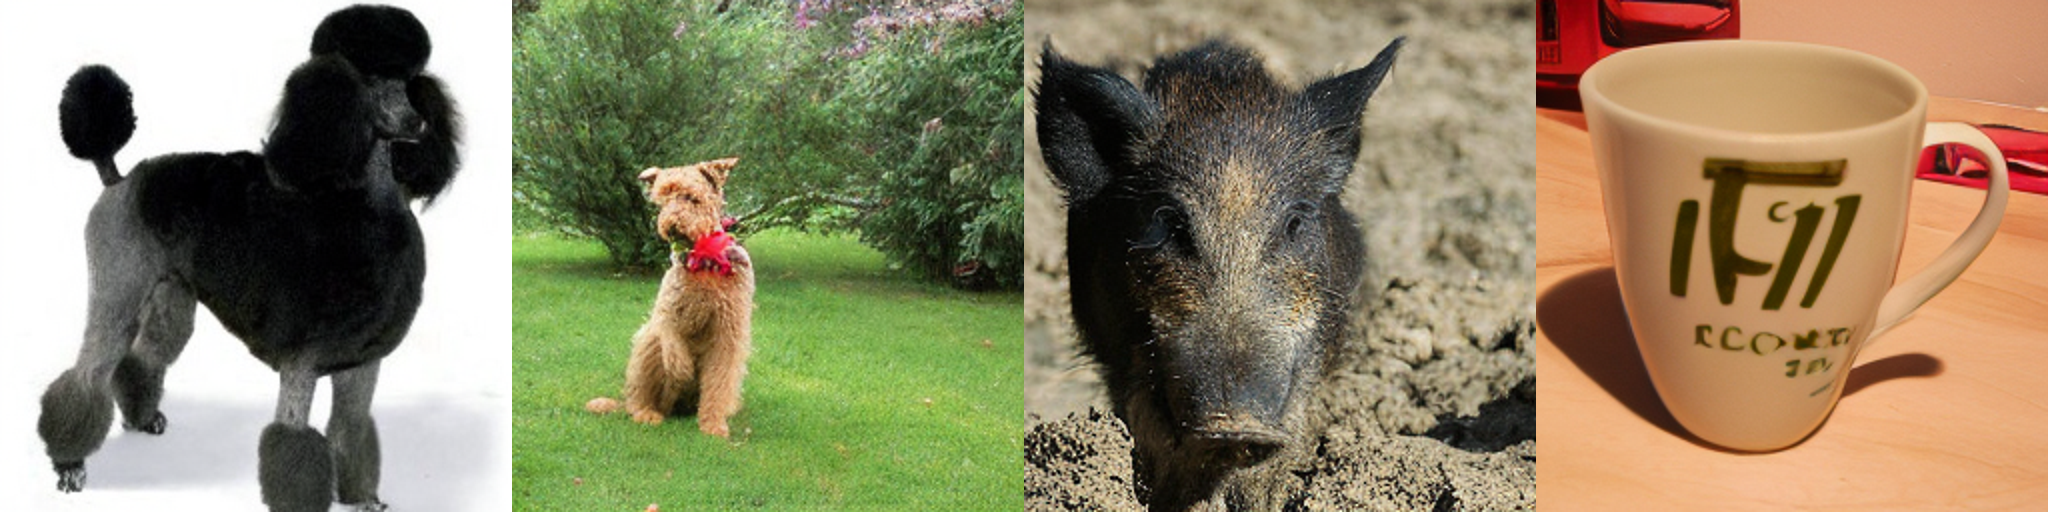

In [5]:
from utils.imagenet_idx_to_classnames import imagenet_idx_to_classnames

# generate samples
device = "cuda:3"  # or "cpu"
class_idx = None #2 #None

images, class_idxs = sample_images(
    model=model, 
    vae=vae,
    class_idx=class_idx,
    batch_size=4, 
    resolution=256, 
    num_steps=100, 
    mode='ode', 
    cfg_scale=2.5, 
    guidance_low=0.0, 
    guidance_high=1.0, 
    path_type='linear', 
    num_classes=1000,
    device=device
)

class_names = [imagenet_idx_to_classnames[x] for x in class_idxs]
if class_idx is None:
    # Display the sampled images directly in the notebook
    for img, class_name in zip(images, class_names):
        print (class_name)
        display(img)

print (class_names)
display_alongside_batch(images)

In [6]:
imagenet_idx_to_classnames

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

## 1.2 - Extract DINO and Diffusion features

In [7]:
from dataclasses import dataclass
from typing import Literal

@dataclass
class repaArgs:
    # Logging and I/O
    output_dir: str = "exps"
    exp_name: str = "my_experiment"  # originally required; provide a default
    logging_dir: str = "logs"
    report_to: str = "wandb"
    sampling_steps: int = 10000
    resume_step: int = 0

    # Model
    model: str = "SiT-XL/2"
    num_classes: int = 1000
    # encoder_depth: int = 8
    encoder_depth: int = 20
    fused_attn: bool = True
    qk_norm: bool = False

    # Dataset
    data_dir: str = "./data/"
    resolution: int = 256
    batch_size: int = 256

    # Precision
    allow_tf32: bool = False
    mixed_precision: Literal["no", "fp16", "bf16"] = "fp16"

    # Optimization
    epochs: int = 1400
    max_train_steps: int = 400000
    checkpointing_steps: int = 40000
    gradient_accumulation_steps: int = 1
    learning_rate: float = 1e-4
    adam_beta1: float = 0.9
    adam_beta2: float = 0.999
    adam_weight_decay: float = 0.0
    adam_epsilon: float = 1e-08
    max_grad_norm: float = 1.0

    # Seed
    seed: int = 0

    # CPU-related
    num_workers: int = 4

    # Loss
    path_type: Literal["linear", "cosine"] = "linear"
    prediction: Literal["v"] = "v"  # currently only 'v' supported
    cfg_prob: float = 0.1
    enc_type: str = "dinov2-vit-b"
    proj_coeff: float = 0.5
    weighting: str = "uniform"
    legacy: bool = False

    # Additional model/vae params from your initial snippet
    vae: str = "ema"
    projector_embed_dims: str = "768"
    ckpt: str = "./pretrained_models/last.pt"

# train dataset
from dataset import CustomDataset, CustomZipDataset, CustomH5Dataset

def load_train_dataset(args):
    if (os.path.exists(os.path.join(args.data_dir, "images")) and
        os.path.exists(os.path.join(args.data_dir, "vae-sd"))):
        train_dataset = CustomDataset(args.data_dir)
    elif (os.path.exists(os.path.join(args.data_dir, "images.h5")) and
          os.path.exists(os.path.join(args.data_dir, "vae-sd.h5")) and
          os.path.exists(os.path.join(args.data_dir, "images_h5.json")) and
          os.path.exists(os.path.join(args.data_dir, "vae-sd_h5.json"))):
            train_dataset = CustomH5Dataset(args.data_dir)
    elif (os.path.exists(os.path.join(args.data_dir, "images.zip")) and
          os.path.exists(os.path.join(args.data_dir, "vae-sd.zip"))):
        train_dataset = CustomZipDataset(args.data_dir)
    else:
        raise ValueError("Dataset not found.")
    return train_dataset

from utils import load_encoders
def load_perception_encoders(args):
    if args.enc_type != 'None':
        encoders, encoder_types, architectures = load_encoders(args.enc_type, device)
    else:
        encoders, encoder_types, architectures = [None], [None], [None]
    return encoders, encoder_types, architectures

In [8]:
# load args and training dataset
args = repaArgs()
print(args)

repaArgs(output_dir='exps', exp_name='my_experiment', logging_dir='logs', report_to='wandb', sampling_steps=10000, resume_step=0, model='SiT-XL/2', num_classes=1000, encoder_depth=20, fused_attn=True, qk_norm=False, data_dir='./data/', resolution=256, batch_size=256, allow_tf32=False, mixed_precision='fp16', epochs=1400, max_train_steps=400000, checkpointing_steps=40000, gradient_accumulation_steps=1, learning_rate=0.0001, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, seed=0, num_workers=4, path_type='linear', prediction='v', cfg_prob=0.1, enc_type='dinov2-vit-b', proj_coeff=0.5, weighting='uniform', legacy=False, vae='ema', projector_embed_dims='768', ckpt='./pretrained_models/last.pt')


In [9]:
args.enc_type, device

('dinov2-vit-b', 'cuda:3')

In [10]:
from loss import SILoss

# get training dataset, encoders and loss_fn
train_dataset = load_train_dataset(args)  # Uses args.data_dir
encoders, encoder_types, architectures = load_perception_encoders(args)

def get_loss_fn(args):
    # create loss function
    loss_fn = SILoss(
        prediction=args.prediction,
        path_type=args.path_type, 
        encoders=encoders,
        accelerator=None, # since we only need the interpolation fn
        latents_scale=None,# since we only need the interpolation fn
        latents_bias=None,# since we only need the interpolation fn
        weighting=args.weighting
    )
    return loss_fn


loss_fn = get_loss_fn(args)

Using cache found in /home/lengx/.cache/torch/hub/facebookresearch_dinov2_main
/home/lengx/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/lengx/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/lengx/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [11]:
import torch
from torch.utils.data import DataLoader
from train import sample_posterior, preprocess_raw_image

# Model should be in eval mode if we're just extracting features
model.eval()

def get_batch_features(
    model, 
    vae, 
    encoders, 
    encoder_types, 
    architectures, 
    train_dataset, 
    loss_fn,
    device='cuda', 
    batch_size=8,
    use_projection=True, 
    t_start=0.,
    t_end=1.,
):
    # Setup scale/bias for latents
    latents_scale = torch.tensor([0.18215]*4).view(1,4,1,1).to(device)
    latents_bias = torch.tensor([0.0]*4).view(1,4,1,1).to(device)

    # Get one batch
    temp_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    raw_image, x, y = next(iter(temp_loader))
    raw_image = raw_image.to(device)
    x = x.squeeze(dim=1).to(device)
    y = y.to(device)

    # If needed, handle cfg_prob / legacy label dropping here. For simplicity:
    labels = y

    with torch.no_grad():
        # Convert VAE latents to model latents
        x = sample_posterior(x, latents_scale=latents_scale, latents_bias=latents_bias)

        # Extract encoder features
        zs = []
        for encoder, encoder_type, arch in zip(encoders, encoder_types, architectures):
            raw_image_ = preprocess_raw_image(raw_image, encoder_type)
            z = encoder.forward_features(raw_image_)
            if 'mocov3' in encoder_type:
                z = z[:, 1:]
            if 'dinov2' in encoder_type:
                z = z['x_norm_patchtokens']
            zs.append(z)

        # Sample a random time step (uniform weighting)
        time_input = torch.rand((x.shape[0], 1, 1, 1), device=device, dtype=x.dtype)
        # limit to the given range
        time_input = time_input * (t_end - t_start) + t_start
        
        alpha_t, sigma_t, d_alpha_t, d_sigma_t = loss_fn.interpolant(time_input)
        noises = torch.randn_like(x)
        model_input = alpha_t * x + sigma_t * noises
        model_target = d_alpha_t * x + d_sigma_t * noises

        # Forward pass through the model to get zs_tilde and predictions
        model_output, zs_tilde, _ = model(model_input, time_input.flatten(), y=labels, use_projection=use_projection)
        # model_output, zs_tilde = model(model_input, time_input.flatten(), y=labels, use_projection=use_projection)

    return {
        "raw_image": raw_image,
        "model_input": model_input,
        "zs": zs,
        "zs_tilde": zs_tilde,
        "model_output": model_output,
        "time_input": time_input,
        "model_target": model_target,
    }

In [12]:
# Example usage in a Jupyter cell:
model.encoder_depth = args.encoder_depth

total_bs = 256
bs = 8
features = {}
t_start = 0.499
t_end = 0.501


for _ in range(total_bs // bs):
    feats = get_batch_features(
        model=model,
        vae=vae,
        encoders=encoders,
        encoder_types=encoder_types,
        architectures=architectures,
        train_dataset=train_dataset,
        use_projection=False,  # <-- we shouldn't use the projection head here...
        loss_fn=loss_fn,
        device=device,
        batch_size=bs,
        t_start=t_start,
        t_end=t_end,
    )
    for k, v in feats.items():
        if k not in features:
            features[k] = []
        # We should be only using one encoder, safely take the first element
        if k in ["zs", "zs_tilde"]:
            features[k].append(feats[k][0])
        else:
            features[k].append(v)

for k, v in features.items():
    features[k] = torch.cat(v, dim=0)
    # Group them back as a list...
    if k in ["zs", "zs_tilde"]:
        features[k] = [features[k]]

In [13]:
# # Printing the requested details nicely
# print("Keys in features:\n", list(features.keys()), "\n")

# print(f"Shape of raw_image:\n{features['raw_image'].shape}\n")

# print("Shapes of model_input, model_output, model_target:\n", f"{features['model_input'].shape}, {features['model_output'].shape}, {features['model_target'].shape}\n")

# print(f"Lengths of zs and zs_tilde:\n{len(features['zs'])}, {len(features['zs_tilde'])}\n")

# print("Shapes of first elements in zs and zs_tilde:\n", 
#       f"{features['zs'][0].shape}, {features['zs_tilde'][0].shape}\n")

In [14]:
features.keys()

dict_keys(['raw_image', 'model_input', 'zs', 'zs_tilde', 'model_output', 'time_input', 'model_target'])

In [15]:
features['raw_image'].shape

torch.Size([256, 3, 256, 256])

In [16]:
# vae style features but for different timesteps
features['model_input'].shape, features['model_output'].shape, features['model_target'].shape

(torch.Size([256, 4, 32, 32]),
 torch.Size([256, 4, 32, 32]),
 torch.Size([256, 4, 32, 32]))

In [17]:
len(features['zs']), len(features['zs_tilde'])

(1, 1)

In [18]:
# encoder (dino) and  diffusion features (after projection)
features['zs'][0].shape, features['zs_tilde'][0].shape

(torch.Size([256, 256, 768]), torch.Size([256, 256, 1152]))

In [19]:
features['time_input'].shape

torch.Size([256, 1, 1, 1])

In [20]:
# alignment score
from metrics import AlignmentMetrics
feat_A = features['zs'][0].mean(dim=1) # B, D
feat_B = features['zs_tilde'][0].mean(dim=1) # # B, D
alignment_score = AlignmentMetrics.measure('cknna', feat_A, feat_B, topk=10)

Please install the pymp library using `pip install pymp` to speed up non-batched metrics


In [21]:
alignment_score

0.08253583059244413

# 2.1 - Analyse feature alignment and correlation with model performance

In [12]:
def get_alignment_score(model, layer_idx=8, batch_size=8, topk=2, use_projection=True, t_start=0., t_end=1., small_bs=16, metrics='cknna'):
    # change layer idx for extracting features from the 
    model.encoder_depth = layer_idx
    
    # extract features
    feat_A = []
    feat_B = []
    for _ in range(batch_size // small_bs):
        features = get_batch_features(
            model=model,
            vae=vae,
            encoders=encoders,
            encoder_types=encoder_types,
            architectures=architectures,
            train_dataset=train_dataset,
            loss_fn=loss_fn,
            device=device,
            # batch_size=batch_size,
            batch_size=small_bs,
            use_projection=use_projection,
            t_start=t_start,
            t_end=t_end,
        )
        feat_A.append(features['zs'][0])
        feat_B.append(features['zs_tilde'][0])

    # compute alignment score
    # alignment score
    # feat_A = features['zs'][0]#.mean(dim=1) # B, D
    # feat_B = features['zs_tilde'][0]#.mean(dim=1) # # B, D
    # feat_A = torch.cat(feat_A, dim=0).mean(dim=1)
    # feat_B = torch.cat(feat_B, dim=0).mean(dim=1)
    # alignment_score = AlignmentMetrics.measure('cknna', feat_A, feat_B, topk=topk)
    # alignment_score = AlignmentMetrics.patch2patch_kernel_alignment_score(feat_A, feat_B)
    # alignment_score = AlignmentMetrics.sample2sample_kernel_alignment_score(feat_A, feat_B)
    # alignment_score = patch2patch_kernel_alignment_score(feat_A, feat_B)

    rtn = {}
    for metric in metrics.split(","):
        metric = metric.strip()
        if "kernel_alignment_score" in metric:
            # Preprocess features for our kernel alignment score dimension requirements
            feat_A = features['zs'][0]#.mean(dim=1) # B, D
            feat_B = features['zs_tilde'][0]#.mean(dim=1) # # B, D
        else:
            feat_A = torch.cat(feat_A, dim=0).mean(dim=1)
            feat_B = torch.cat(feat_B, dim=0).mean(dim=1)

        if "nn" in metric:
            # NN-based metric require topk argument
            kwargs = {"topk": topk}
        else:
            kwargs = {}
        alignment_score = AlignmentMetrics.measure(metric, feat_A, feat_B, **kwargs)
        rtn[metric] = alignment_score
    return rtn

In [23]:
# Import necessary libraries
import matplotlib.pyplot as plt
from tqdm import tqdm

# hyperparams
batch_size=512
topk=10
layer_start=1
layer_end=28
use_projection = False
t_start = 0.0
t_end = 0.01
# metrics = "cknna"
# metrics = "sample2sample_kernel_alignment_score"
# metrics = "patch2patch_kernel_alignment_score"
# metrics = "sample2sample_kernel_alignment_score_kl_div"
# metrics = "patch2patch_kernel_alignment_score_kl_div"
metrics = ",".join(["cknna", "sample2sample_kernel_alignment_score", "patch2patch_kernel_alignment_score", "sample2sample_kernel_alignment_score_kl_div", "patch2patch_kernel_alignment_score_kl_div"])

alignment_scores = []
# Compute alignment scores with tqdm for progress
for layer_idx in tqdm(range(layer_start,layer_end), desc="Computing Alignment Scores"):
    score = get_alignment_score(model, layer_idx=layer_idx, batch_size=batch_size, topk=topk, use_projection=use_projection, t_start=t_start, t_end=t_end, small_bs=8, metrics=metrics)
    alignment_scores.append(score)

Computing Alignment Scores:   0%|                                                                                                                                                                                                     | 0/27 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7fe3f036e160>
Traceback (most recent call last):
  File "/mnt/SSD/lengx/miniconda3/envs/repa/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Exception ignored in: <function _releaseLock at 0x7fe3f036e160>
Traceback (most recent call last):
  File "/mnt/SSD/lengx/miniconda3/envs/repa/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Computing Alignment Scores:   4%|███████                                                                                                                                                                                      | 1/27 [00:41<17:48, 41.09s

In [ ]:
alignment_scores

[{'cknna': 0.037964314906303434,
  'sample2sample_kernel_alignment_score': 0.5698162317276001,
  'patch2patch_kernel_alignment_score': 0.7806989550590515,
  'sample2sample_kernel_alignment_score_kl_div': 0.05733330547809601,
  'patch2patch_kernel_alignment_score_kl_div': 0.02296937257051468},
 {'cknna': 0.021386618672146904,
  'sample2sample_kernel_alignment_score': 0.54908686876297,
  'patch2patch_kernel_alignment_score': 0.785896360874176,
  'sample2sample_kernel_alignment_score_kl_div': 0.05770767107605934,
  'patch2patch_kernel_alignment_score_kl_div': 0.022818058729171753},
 {'cknna': 0.02288491966673392,
  'sample2sample_kernel_alignment_score': 0.5378190279006958,
  'patch2patch_kernel_alignment_score': 0.796185314655304,
  'sample2sample_kernel_alignment_score_kl_div': 0.0630803257226944,
  'patch2patch_kernel_alignment_score_kl_div': 0.023066218942403793},
 {'cknna': 0.06089313800163853,
  'sample2sample_kernel_alignment_score': 0.5478090047836304,
  'patch2patch_kernel_alignm

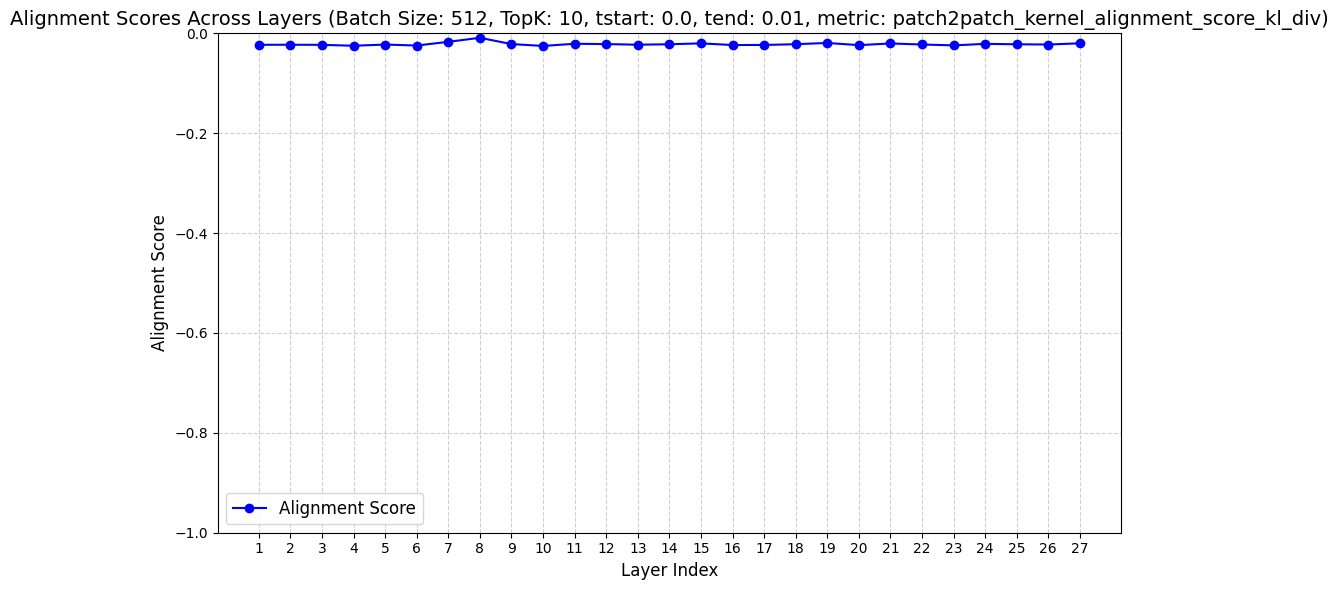

In [50]:
# Plot the alignment scores
# metric = "cknna"
# metric = "sample2sample_kernel_alignment_score"
# metric = "patch2patch_kernel_alignment_score"
# metric = "sample2sample_kernel_alignment_score_kl_div"
metric = "patch2patch_kernel_alignment_score_kl_div"
plt.figure(figsize=(10, 6))
plt.plot(range(layer_start,layer_end), -np.array([elem[metric] for elem in alignment_scores]), marker='o', linestyle='-', color='b', label='Alignment Score')
plt.title(f"Alignment Scores Across Layers (Batch Size: {batch_size}, TopK: {topk}, tstart: {t_start}, tend: {t_end}, metric: {metric})", fontsize=14)
plt.xlabel("Layer Index", fontsize=12)
plt.ylabel("Alignment Score", fontsize=12)
plt.ylim(-1, 0)
plt.xticks(range(layer_start, layer_end, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 2.2 - The training steps v.s. alignment score curve

In [13]:
def get_max_alignment_across_layers(model, batch_size=256, layer_start=1, layer_end=28, topk=10, use_projection=False, t_start=0., t_end=1., small_bs=16, metrics="cknna"):
    alignment_scores = []
    metric = [elem.strip() for elem in metrics.split(",")]
    assert len(metric) == 1, "Only one metric is supported for this function for now."
    metric = metric[0]
    # Compute alignment scores with tqdm for progress
    for layer_idx in tqdm(range(layer_start,layer_end), desc="Computing Alignment Scores"):
        score = get_alignment_score(model=model, layer_idx=layer_idx, batch_size=batch_size, topk=topk, use_projection=use_projection, t_start=t_start, t_end=t_end, small_bs=small_bs, metrics=metrics)
        alignment_scores.append(score)
    alignment_scores = [elem[metric] for elem in alignment_scores]  # <-- the metric
    alignment_scores = torch.tensor(alignment_scores)
    return torch.max(alignment_scores).item(), torch.argmax(alignment_scores).item() + layer_start

In [25]:
batch_size = 512
layer_start = 4
layer_end = 20
topk = 10
use_projection = False
t_start = 0.499
t_end = 0.501
metrics = "cknna"

max_alignment_score, max_alignment_score_pos = get_max_alignment_across_layers(
    model=model,
    batch_size=batch_size,
    layer_start=layer_start,
    layer_end=layer_end,
    topk=topk,
    use_projection=use_projection,
    t_start=t_start,
    t_end=t_end,
    metrics=metrics
)

print(f"Max alignment score: {max_alignment_score:.4f} @ layer {max_alignment_score_pos}")

Computing Alignment Scores:  12%|███████████████████████▋                                                                                                                                                                     | 2/16 [01:27<10:09, 43.53s/it]


KeyboardInterrupt: 

In [29]:
import gc

del model
del state_dict

gc.collect()
torch.cuda.empty_cache()

In [16]:
# Load different model checkpoints and see the trend
import gc

@dataclass
class repaArgs():
    vae = 'ema'
    model = 'SiT-XL/2'
    # model = "SiT-B/2"
    num_classes = 1000
    encoder_depth = 8
    projector_embed_dims = "768"
    fused_attn = True
    qk_norm = False
    resolution = 256
    ckpt_steps_path = "exps/sit-xl-linear-dinov2-b-enc8-400k/checkpoints"
    # ckpt_steps_path = "exps/sit-b-base-400k/checkpoints"
    data_dir = './data/'
    batch_size = 512
    # layer_start = 1
    # layer_end = 28  # SiT-XL/2
    # layer_end = 12  # SiT-B/2
    layer_start = 5  # SiT-XL/2, curr exp
    layer_end = 11  # SiT-XL/2, curr exp
    topk = 10
    use_projection = False
    t_start = 0.499
    t_end = 0.501
    # small_bs = 32  # SiT-B/2
    small_bs = 32
    metrics = "cknna"

args = repaArgs()
device = "cuda:3"

ckpt_paths = [os.path.join(args.ckpt_steps_path, elem) for elem in sorted(os.listdir(args.ckpt_steps_path)) if elem.endswith('.pt')]
steps = [int(elem.split('/')[-1].split('.')[0]) for elem in ckpt_paths]
max_alignment_scores = []

for step, ckpt_path in tqdm(zip(steps, ckpt_paths), total=len(steps)):
    block_kwargs = {"fused_attn": args.fused_attn, "qk_norm": args.qk_norm}
    latent_size = args.resolution // 8
    model = SiT_models[args.model](
        input_size=latent_size,
        num_classes=args.num_classes,
        use_cfg = True,
        z_dims = [int(z_dim) for z_dim in args.projector_embed_dims.split(',')],
        encoder_depth=args.encoder_depth,
        **block_kwargs,
    ).to(device)

    state_dict = torch.load(ckpt_path, map_location="cpu")#['ema']
    if "model" in state_dict:
        state_dict = state_dict["model"]
    model.load_state_dict(state_dict)
    model.eval()  # important!

    # cleanup to avoid OOM
    gc.collect()
    torch.cuda.empty_cache()

    max_alignment_score, max_alignment_score_pos = get_max_alignment_across_layers(
        model=model,
        batch_size=args.batch_size,
        layer_start=args.layer_start,
        layer_end=args.layer_end,
        topk=args.topk,
        use_projection=args.use_projection,
        t_start=args.t_start,
        t_end=args.t_end,
        small_bs=args.small_bs,
        metrics=args.metrics,
    )
    max_alignment_scores.append(max_alignment_score)

  0%|                                                                                                                                                                                                                                 | 0/10 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                                                                 | 0/10 [00:48<?, ?it/s]


NameError: name 'AlignmentMetrics' is not defined

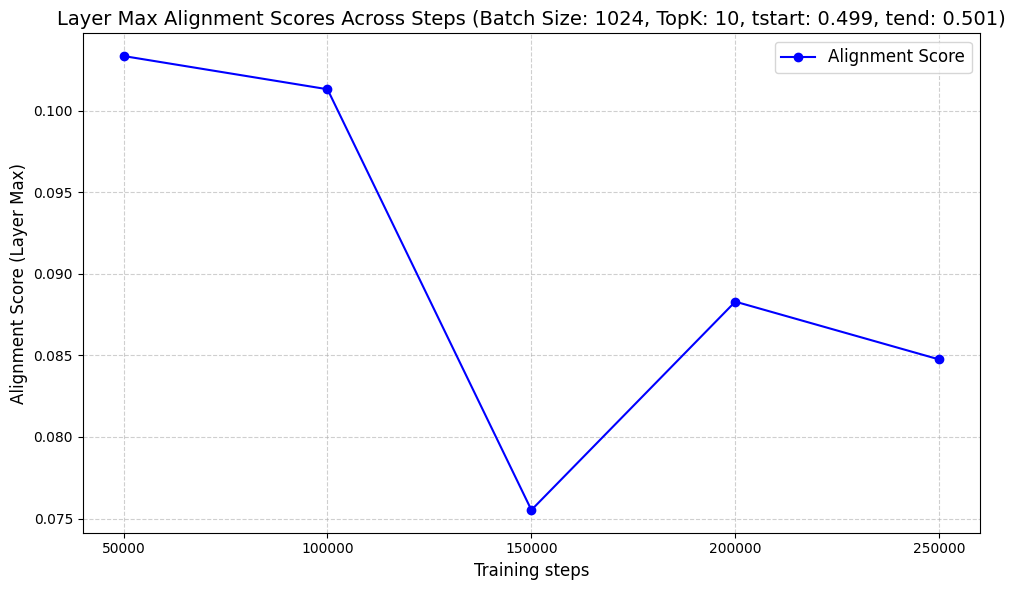

In [ ]:
# Plot the trend

plt.figure(figsize=(10, 6))
plt.plot(steps, max_alignment_scores, marker='o', linestyle='-', color='b', label='Alignment Score')
plt.title(f"Layer Max Alignment Scores Across Steps (Batch Size: {args.batch_size}, TopK: {args.topk}, tstart: {args.t_start}, tend: {args.t_end})", fontsize=14)
plt.xlabel("Training steps", fontsize=12)
plt.ylabel("Alignment Score (Layer Max)", fontsize=12)
# plt.ylim(0, 1)
plt.xticks(steps)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


# 3 - Design kernel alignment metric and loss

# Debug